# Image Reconstruction from Sinograms
## **A Tutorial on CT Reconstruction in NumPy and PyTorch**

## **Overview**
This tutorial explores how tomographic image reconstruction can be implemented using direct matrix methods and custom-coded forward/backprojection routines. The goal is to demystify CT reconstruction by showing how core techniques like **backprojection**, **filtered backprojection (FBP)**, and **iterative algorithms** such as **SIRT** and **CGLS** can be implemented from first principles.

We demonstrate that reconstructions can be achieved using two main approaches:
- A **matrix-based method**, where the forward model is explicitly represented as a system matrix **A**.
- A **functional method**, where forward and backprojectors are implemented using `scipy.ndimage.rotate` in for-loops.

Both approaches yield similar reconstruction results, and we will show their equivalence visually.

Importantly, this tutorial also introduces **GPU acceleration using PyTorch**, showcasing how much faster reconstructions become when using the same forward/backprojector logic with CUDA support. This is particularly useful when scaling to larger image sizes or for training machine learning models on synthetic reconstructions.

## **Objectives**
By the end of this tutorial, you will:
- Understand how to represent the CT forward model as a matrix **A** and use it for direct and iterative reconstruction.
- Implement custom forward and backprojectors using simple NumPy and `rotate`-based loops.
- Compare reconstruction quality and runtime across methods.
- Accelerate the same reconstruction logic using PyTorch with GPU support.
- Gain insight into why matrix methods don’t scale well and when loop-based approaches become preferable.

## **Reconstruction Methods Covered**

### **1. Backprojection (BP)**
The simplest form of reconstruction, implemented by smearing each projection back along its acquisition angle. It yields a blurred image but forms the basis for FBP and iterative methods.

### **2. Filtered Backprojection (FBP)**
A fast analytic method that applies a ramp filter in the frequency domain before backprojection. This produces high-quality results for noise-free or well-conditioned sinograms.

### **3. Iterative Methods: SIRT and CGLS**
These methods solve the inverse problem iteratively by minimizing the error between measured and simulated projections:
- **SIRT** (Simultaneous Iterative Reconstruction Technique) is simple and stable.
- **CGLS** (Conjugate Gradient for Least Squares) converges quickly and handles large systems efficiently.

### **4. Matrix-Based Forward Model**
The forward operator is represented explicitly as a sparse matrix **A**, allowing for direct inversion or use in iterative solvers via `A.T @ (A @ x - b)`. This method is mathematically transparent but limited in scalability due to memory constraints.

### **5. Custom Loop-Based Forward/Backward Operators**
Here, forward projection is performed using rotation-based integration across the object. This mimics the behavior of a real scanner and allows reconstruction on large-scale images without forming **A** explicitly.

### **6. PyTorch GPU Acceleration**
All of the above methods can be ported to PyTorch and run on GPU. This dramatically speeds up reconstruction, particularly for iterative methods or large sinogram stacks.

## **Why This Matters**
- Reconstruction is the core of computed tomography, and understanding how it works under the hood enables better debugging, algorithm development, and performance optimization.
- Many advanced ML-based approaches (e.g., learned iterative reconstructions) build on these foundations.
- This notebook provides a minimal, educational implementation of these techniques that can be scaled, extended, or incorporated into your own imaging workflows.

Let’s now walk through each reconstruction approach step by step — from matrix formulation to GPU acceleration — and evaluate their accuracy and performance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import iradon, radon
from tqdm import tqdm

from nDTomo.sim.phantoms import SheppLogan
from nDTomo.tomo.conv_tomo import filter_sinogram, backproject


First we create a phantom object that we will use for our simulations

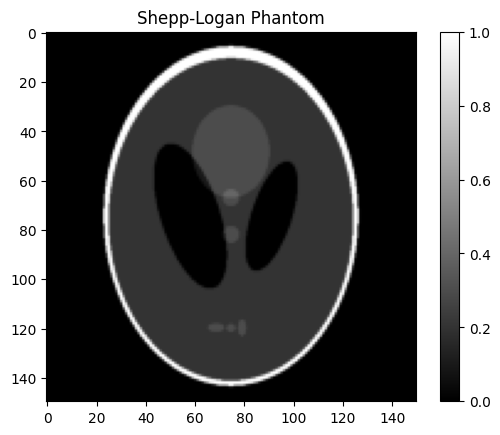

In [ ]:
npix = 151
img = SheppLogan(npix)

plt.figure(1);plt.clf()
plt.imshow(img, cmap='gray')
plt.title('Shepp-Logan Phantom')
plt.colorbar()
plt.show()


### Filtering Sinograms in the Frequency Domain

Before performing backprojection, it's essential to filter the sinogram to correct for the inherent blurring introduced by the projection process. This is a key step in Filtered Backprojection (FBP) and is based on the physics of how the Radon transform behaves in frequency space.

The `filter_sinogram` function performs this filtering operation using the **Fourier slice theorem**, which states that each projection is a slice of the 2D Fourier transform of the object. Here's what happens:

1. **FFT Along Detector Axis**: Each projection (column in the sinogram) is Fourier transformed along the detector axis. This gives us a frequency representation of each projection.
2. **Apply Filter**: A filter is applied in the frequency domain. Two options are available:
   - **Ramp filter (Ram-Lak)**: Enhances high-frequency components to correct for blurring.
   - **Shepp-Logan filter**: A smoother version of the ramp, which reduces noise amplification by multiplying with a sinc function.
3. **Inverse FFT**: The filtered projections are transformed back to the spatial domain via inverse FFT.

This filtered sinogram can then be used for high-quality image reconstruction. Without this step, backprojection would produce a highly blurred result.

#### Code:
```python
def filter_sinogram(sinogram, filter_type='Ramp'):
    """
    Applies a frequency domain filter to a sinogram.

    Parameters
    ----------
    sinogram : ndarray
        2D array of shape (num_detectors, num_angles).
    filter_type : str
        Type of filter to apply. Options:
        - 'Ramp' : standard Ram-Lak filter
        - 'Shepp-Logan' : Ramp * sinc

    Returns
    -------
    filtered_sinogram : ndarray
        The filtered sinogram with the same shape as input.
    """
    n, n_theta = sinogram.shape
    f = fftfreq(n).reshape(-1, 1)

    # Ramp filter
    ramp = np.abs(f)

    if filter_type == 'Ramp':
        filt = ramp
    elif filter_type == 'Shepp-Logan':
        filt = ramp * np.sinc(f / (2 * f.max()))
    else:
        raise ValueError("Unsupported filter_type. Choose 'Ramp' or 'Shepp-Logan'.")

    # FFT along detector axis (rows)
    sino_fft = fft(sinogram, axis=0)
    sino_fft_filtered = sino_fft * filt
    filtered_sinogram = np.real(ifft(sino_fft_filtered, axis=0))

    return filtered_sinogram


The number of angles is 150
178.79999999999998


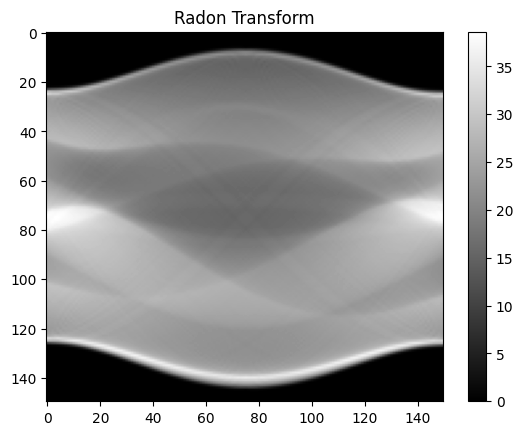

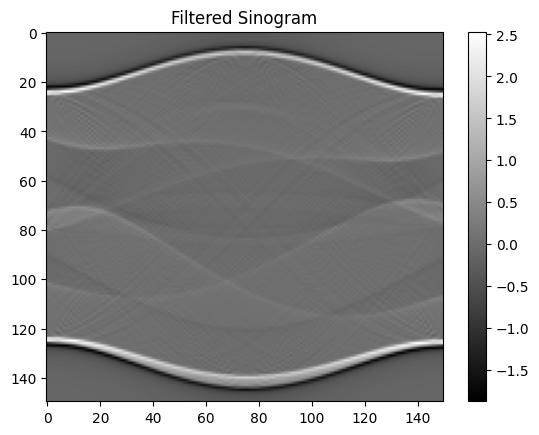

In [30]:

scan = 180
theta = np.linspace(0, scan, 150, endpoint=False)
print('The number of angles is', len(theta))
print(theta[-1])

s = radon(img, theta) 

fbp = iradon(s, theta, filter_name='ramp', output_size=npix)
fbp[fbp < 0] = 0    

plt.figure(1);plt.clf()
plt.imshow(s, cmap='gray')
plt.title('Radon Transform')
plt.colorbar()
plt.axis('tight')
plt.show()

sf = filter_sinogram(s, filter_type='Ramp')

plt.figure(1);plt.clf()
plt.imshow(sf, cmap='gray')
plt.title('Filtered Sinogram')
plt.colorbar()
plt.axis('tight')
plt.show()


### Backprojection: Reconstructing from Filtered Projections

Backprojection is the process of reconstructing a 2D image from a set of 1D projections acquired at different angles. It's the core idea behind tomographic imaging, and here we implement it in the most intuitive way possible.

The `backproject` function works as follows:

1. **For Each Angle**:
   - A 1D projection is extracted from the sinogram.
   - This projection is **replicated along columns** to form a 2D image — this mimics smearing the projection across the reconstruction plane.
   - The 2D image is then **rotated to the corresponding acquisition angle** (plus 90° to align with the Radon geometry).

2. **Accumulation**:
   - Each rotated projection is **added** to the reconstruction buffer.
   - After all angles are processed, the image contains the accumulated backprojections.

3. **Normalization**:
   - The final result is scaled by π * N_theta, where N_theta is the number of projection angles. This compensates for overaccumulation during the sum.

This method visually reinforces the concept of backprojection: each projection "casts" its information across the reconstruction plane, and the full image is recovered by combining all such projections.

It’s a simple and elegant approach — ideal for learning and debugging — even though it’s slower than matrix-based or GPU-accelerated implementations.

#### Code:
```python

def backproject(sinogram, angles, output_size=None, scan=180):
    """
    Performs filtered or unfiltered backprojection of a sinogram.

    Parameters
    ----------
    sinogram : ndarray
        2D array of shape (num_detectors, num_angles).
    angles : ndarray
        1D array of projection angles in degrees.
    output_size : int, optional
        Size (width and height) of the reconstructed image.
        If None, use num_detectors from sinogram.

    Returns
    -------
    reconstruction : ndarray
        2D reconstructed image.
    """
    n_detectors, n_angles = sinogram.shape
    if output_size is None:
        output_size = n_detectors

    reconstruction = np.zeros((output_size, output_size), dtype=np.float32)

    for i, theta in enumerate(angles):
        projection = sinogram[:, i]

        # Expand the 1D projection to a 2D image (replicate across columns)
        projection_2d = np.tile(projection[:, np.newaxis], (1, output_size))

        # Rotate the 2D projection to the current angle
        rotated = rotate(projection_2d, angle= theta + 90, reshape=False, order=3)

        # Accumulate into reconstruction
        reconstruction += rotated

    # Normalize
    reconstruction *= np.pi / (n_angles)

    return reconstruction

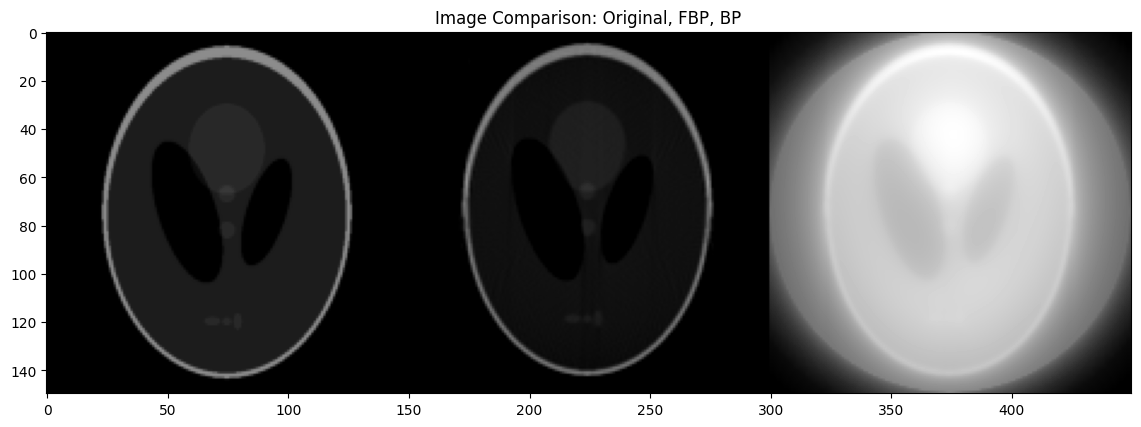

In [31]:

fbp = backproject(sf, theta)
fbp[fbp < 0] = 0

bp = backproject(s, theta) * np.pi / (s.shape[1])
bp[bp < 0] = 0


imc = np.concatenate((img, fbp, bp), axis=1)

plt.figure(1, figsize=(14, 14));plt.clf()
plt.imshow(imc, cmap='gray')
plt.title('Image Comparison: Original, FBP, BP')
plt.show()


### CT Reconstruction Using a Sparse System Matrix `A`

In the matrix-based formulation of tomography, we describe the entire projection and reconstruction process using a **linear system**:

$$
A \cdot x = b
$$

- `x` is the vectorized 2D image (unknown — what we want to reconstruct).
- `b` is the measured sinogram, flattened into a 1D vector.
- `A` is the **system matrix** that models the geometry of the scanner — each row of `A` represents the contribution of all pixels to one detector measurement at a specific angle.

This formulation allows us to use linear algebra to solve for `x`. The simplest solution is the **least squares estimate**:

$$
x = (A^\top A)^{-1} A^\top b
$$

But this direct inversion is **not practical** for real-world data due to:

#### 🔍 Key Challenges:
- **Memory usage**: `A` is typically very large but sparse (most entries are zero). For a 256×256 image and 1000 projections, `A` will have 256×1000×256×256 elements!
- **Storage**: We use a **sparse matrix representation** (e.g. CSR/COO) to store only the non-zero elements.
- **Computation**: Instead of inverting `A`, we often use **iterative solvers** like SIRT, SART or CGLS that only require **matrix-vector products** (`A @ x` and `A.T @ y`) — not the matrix itself.

#### 🧱 Constructing `A`:
You can build `A` manually by tracing ray paths from the source to each detector element at each angle. Each ray intersects a subset of pixels, and you compute how much each pixel contributes to the corresponding detector reading.

This process encodes:
- Geometry (angles, detector positions)
- Pixel grid layout
- Integration of intensity along ray paths

#### 🧠 Why Use the `A` Matrix Formulation?
- Provides a **ground truth model** for verifying custom forward/backprojector logic.
- Makes it easy to test and debug with linear solvers.
- Lets you use off-the-shelf optimization tools (e.g. Tikhonov regularization, sparsity constraints).

However, this approach **does not scale well** for large volumes or 3D data. That’s why modern toolkits (like ASTRA or ODL) avoid forming `A` explicitly — instead, they use **operator-based forward and backward projectors** that compute `A @ x` on the fly.

This notebook shows how to:
- Build a simple sparse matrix `A`
- Compare matrix-based and loop-based reconstructions
- Use `A` in iterative solvers like CGLS

In [ ]:
    # N : int
    #     Number of discretization intervals in each dimension, resulting in an N x N domain.
    # theta : array-like
    #     Array of angles in degrees.
    # p : int, optional
    #     Number of parallel rays for each angle. Default is `round(sqrt(2) * N)`.
    # w : float, optional
    #     Width of the ray fan (distance from the first ray to the last). Default is `sqrt(2) * N`.






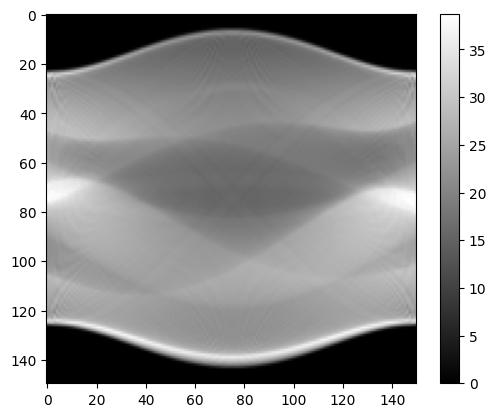

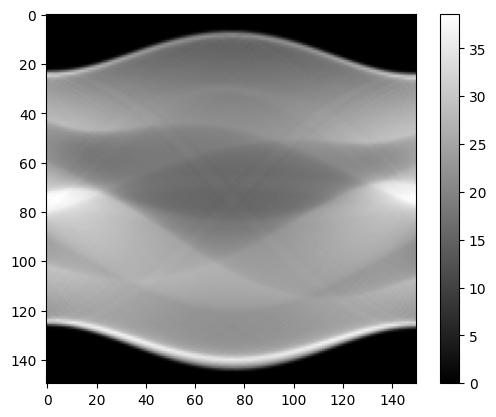

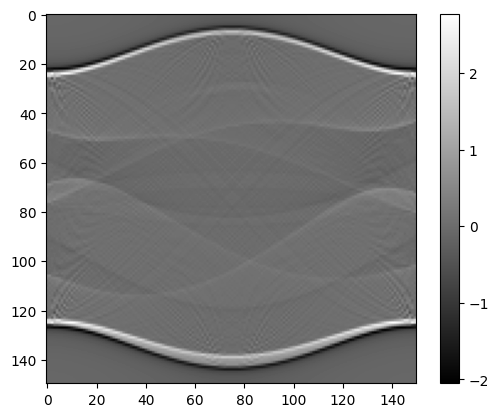

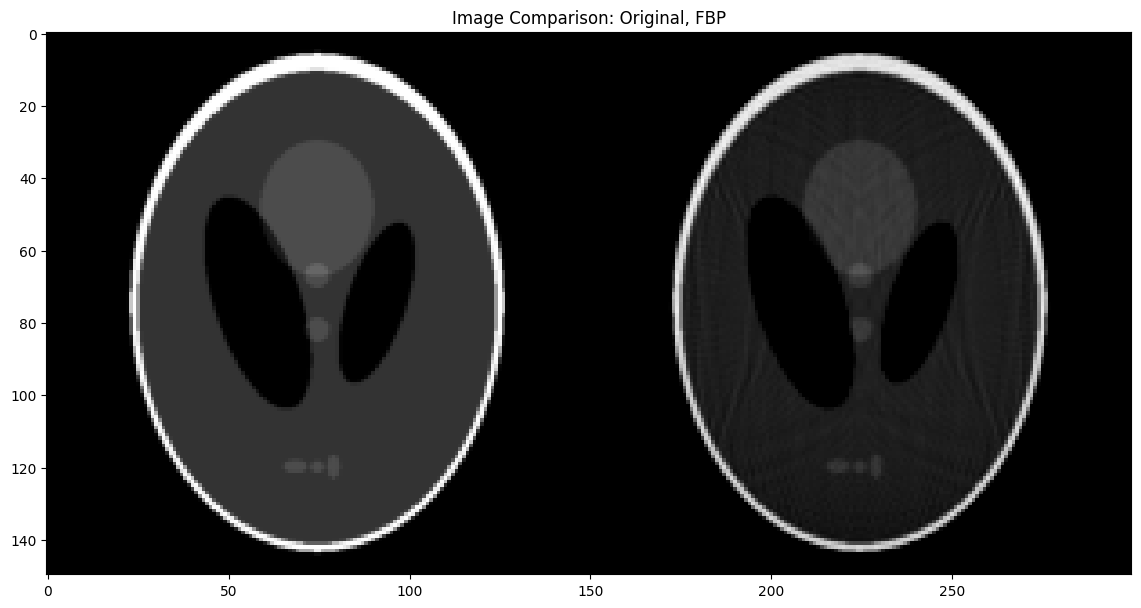

In [32]:
from nDTomo.tomo.conv_tomo import paralleltomo

# A = paralleltomo(N=img.shape[0], theta=theta + 90, p=img.shape[0], w=img.shape[0]-1)
A = paralleltomo(N=img.shape[0], theta=theta + 90, p=img.shape[0], w=img.shape[0]-1)

b = A*img.flatten()
sA = np.transpose(np.reshape(b, (len(theta), npix)))

plt.figure(1);plt.clf()
plt.imshow(sA, cmap='gray')
plt.colorbar()
plt.show()

plt.figure(1);plt.clf()
plt.imshow(s, cmap='gray')
plt.colorbar()
plt.show()

sA = filter_sinogram(sA, filter_type='Ramp')

plt.figure(1);plt.clf()
plt.imshow(sA, cmap='gray')
plt.colorbar()
plt.show()

rec = backproject(sA, theta)
rec = np.fliplr(rec)
rec[rec < 0] = 0

imc = np.concatenate((img, rec), axis=1)

plt.figure(1, figsize=(14, 14));plt.clf()
plt.imshow(imc, cmap='gray')
plt.title('Image Comparison: Original, FBP')
plt.show()


rec = backproject(sA, theta) * np.pi / (s.shape[1])
rec[rec < 0] = 0

imc = np.concatenate((img, rec), axis=1)

plt.figure(1, figsize=(14, 14));plt.clf()
plt.imshow(imc, cmap='gray')
plt.title('Image Comparison: Original, FBP, BP')
plt.show()